# Exploring the Digitised Books Collection from Trove ([GLAM Workbench](https://glam-workbench.github.io/trove-books/))

##### by [Adel Rahmani](https://twitter.com/dinkumdata)
##### This Jupyter notebook can be found on [GitHub](https://github.com/adelr/trove-books)

After my [exploratory data analysis of 12,000 parliamentary press releases](https://nbviewer.jupyter.org/github/adelr/trove-refugee/blob/master/Analyses.ipynb), I started looking through the other collections of digitised documents available on [GLAM Workbench](https://glam-workbench.github.io),
the wonderful platform developed by [Tim Sherratt](https://timsherratt.org/).

One particular collection which caught my attention was the 9,738 digitised books from [Trove Australia](https://trove.nla.gov.au/), which Tim kindly and conveniently made
available on [GLAM Workbench](https://glam-workbench.github.io/trove-books/).

Since the topic modelling computation below is similar to the one I used previously, I'll be going through that part rather quickly. Please see my [notebook on the press releases](https://nbviewer.jupyter.org/github/adelr/trove-refugee/blob/master/Analyses.ipynb) for more details.

A particular feature of this book collection is that it is multilingual, therefore I'll be focusing a bit on that, and on the use of the topic model to figure out what the collection is about.

Let's jump in!

In [2]:
# basic libraries
import pandas as pd
import numpy as np
from pathlib import Path
from itertools import chain

# plotting
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns
%matplotlib inline

# For some nice interactive plots
import altair as alt
alt.renderers.enable('notebook')

# By default, altair requires us to load the data from
# a file if the data source exceeds 5000 rows. 
# I want to load the data from memory instead, hence the
# modified max_rows.
alt.data_transformers.enable('default', max_rows=10000)

def my_theme(*args, **kwargs):
    '''
    Ensure that altair figures have a white
    background instead of a transparent one
    when saving/exporting them.
    '''
    return {
            "background": "white"
          }
          
alt.themes.register('my_theme', my_theme)
alt.themes.enable('my_theme');

# natural language processing
from sklearn.feature_extraction.text import TfidfVectorizer

# matrix factorisation
from sklearn.decomposition import NMF

# dimensionality reduction
from umap import UMAP

# regular expressions
import re

# language detection
import pycld2 as cld2

## Helper functions

These are for the most part the same code snippets as the ones I discussed [previously](https://nbviewer.jupyter.org/github/adelr/trove-refugee/blob/master/Analyses.ipynb)...  

In [3]:
def tokenize(corpus, docs_path, **kwargs):
    '''
    Simple wrapper function around a sklearn 
    TfidfVectorizer object. 
    '''
    # create an instance of the vectoriser
    tfidf = TfidfVectorizer(**kwargs)                             

    # the vectoriser returns a sparse array which
    # we convert to a dense array for convenience
    X_tfidf = np.asarray(tfidf.fit_transform(corpus).todense())

    print(f"Tokenised {X_tfidf.shape[0]} documents using a vocabulary of {len(tfidf.get_feature_names())} tokens.")
    
    return X_tfidf, tfidf

def extract_topics(model, vec, sep=' | ', n=5):
    '''
    Extract topics in terms of vocabulary tokens from
    from a trained tokeniser and a trained NMF model.
    '''
    
    topics = {}
    
    # sort the array so that the most important tokens are first
    idx = model.components_.argsort(axis=1)[:, ::-1]
    
    # extract the most important tokens 
    for i, t in enumerate(np.array(vec.get_feature_names())[idx]):
        topic = sep.join(t[:n])
        topics[i] = topic
    
    return topics

metadata = pd.read_csv('books/trove_digitised_books_with_ocr.csv')

def get_url(doc, metadata=metadata):
    '''
    Get the trove and nla urls for a document from the metadata
    file provided by Tim Sherratt on GLAM Workbench
    '''
    prefix, number = doc.name.partition('nla.obj')[-2:]
    trove_id = prefix + number.split('.')[0]
    nla_url = metadata[metadata.trove_id==trove_id]['fulltext_url'].values[0]
    url = metadata[metadata.trove_id==trove_id]['url'].values[0]
    return (nla_url, url)

def get_most_representative_doc_for_topic(topic, 
                                          n=3, 
                                          docs_path=None, 
                                          df=None, 
                                          plot=True,
                                          print_url=True):            
    '''
    Extract the top n most representative documents for a given topic, 
    based on the topic scores.
    '''
    # sort the results according to the score for the topic of interest
    docs_idx = df.iloc[:, topic].sort_values(ascending=False).index.values[:n]
        
    # extract the top n most representative documents          
    results = np.array(docs_path)[docs_idx]

    # output the results and plot the topic allocations      
    for i, item in zip(docs_idx, results):
        url, url_trove = get_url(item)
        if print_url:
            print(item.name, url, url_trove, sep='\n')
        else:
            print(item.name)
        if plot:  
            plot_topic_allocation(i)
    
    return results
    

STOPWORDS = {'anything', 'mightn', 'upon', 'six', 'herein', 'hers', 'indeed', 'becomes', 'twenty', 'at', 'up', 'will', 'meanwhile', 'same', 'onto', 'seem', 'it', 'had', 'they', "'m", 'beforehand', 'describe', 'was', 'moreover', 'hereupon', 'your', 'due', 'un', 'eleven', 'further', 'him', 'is', 'whereas', 'hasnt', 'in', 'we', 'them', 'ten', 
'however', 'done', 'fire', 'through', 'keep', 'sometimes', 'unless', 'needn', 'until', 'top', 'there', 'just', 'didn', 'because', 'wherever', 'couldnt', 'front', 'someone', 'afterwards', 'within', 'won', 'except', 'he', 'fill', 'ours', 'my', 'others', 'latterly', 'made', 'first', 'about', 'call', 'may', 'thence', 'seeming', 'nor', 'haven', 'couldn','nothing', 'everyone', 'enough', 'her', 'latter', 'detail', 'now', 'where', 'while', 'became', 'wouldn', 'besides','do', 'its', 'wasn', 'another', 'during', 'around', 'shouldn', 'some', 'whoever', 'once', 'inc', 'con', 'll', 'four','back', 'm', 'although', 've', 'either', 'their', 'beside', 'yourself', 'how', 'when', 'whom', 'sincere', 'thereafter', 'out', 'between', 'whether', 'hereafter', 'she', "'re", 'over', 'thru', 'i', 'very', 'whereupon', 'above', 'third','alone', 'aren', 'nevertheless', 'almost', 'various', 'nowhere', 'so', 'make', 'somehow', 'here', 'take', "'d", 'those','whereby', 'whereafter', 'mill', 'get', 'after', 'into', 'ourselves', 'more', 'regarding', 'quite', 'don', 'ever','everywhere', 'whole', 'five', 'ma', 'whence', 'below', 'eg', 'give', 'under', 'ltd', 'yours', 'd', 'whatever', 'might','be', 'using', 'serious', 'not', 'anyhow', 'ca', 'his', 'becoming', 'who', 'hasn', 'therein', 'again', 'me', 'empty', 'noone', 'being', 't', 'nobody', 'hadn', 'theirs', 'since', 'rather', 'mustn', 'nine', 'from', 'none', 'the', 'seems',"'ve", 'system', 'amongst', 'thereby', 'been', 'own', 'next', 'down', 'hundred', 'each', 'seemed', 'other', 'everything','across', 'ain', 'off', 'doesn', 'than', 'many', 'show', 'but', 'an', 'then', 'never', 'without', 'before', 'only', 'anyway', 'namely', 'o', 'etc', 'formerly', 'wherein', 'two', 'did', 'y', 'toward', 'thereupon', "'ll", 'full', 'most','have', 'always', 'were', 'myself', 'name', 'move', 'say', 'put', 'cry', 'become', 'would', 'to', 'am', 'bottom','having', 'amoungst', 'as', 'already', 'whenever', 'thin', 'us', 'that', 'whither', 'our', 'yourselves', 'cant', 'several', "'s", 'really', 'fifteen', 'otherwise', 'must', 'anywhere', 'much', 'hereby', 'anyone', 'for', 'could', 'often', 'themselves', 'can', 'all', 'too', 'sometime', 'what', 'somewhere', 'every', 'find', 'herself', 'together', 'are', 'well', 'de', 'on', 'which', 'interest', 'bill', 'isn', 'himself', 'therefore', 'whose', 'along', 'has', 'though','mostly', 'please', 'beyond', 'neither', 'against', 'go', 'behind', 'amount', 'something', 'hence', 'part', 'this','and', 'you', 'eight', 'per', 'among', 'least', 'side', 'mine', 'towards', 'see', 'a', 'also', 'by', 'via', 'twelve', 'forty', 'found', 'such', 'less', 'even', 'still', 'these', 'few', 's', 'perhaps', 'both', 'throughout', "n't", 'shan','elsewhere', 'co', 'sixty', 'why', 'one', 'if', 'thus', 'itself', 'used', 'ie', 'of', 'fifty', 'former', 'else', 'or','three', 'cannot', 'last', 'any', 'thick', 'no', 're', 'with', 'should', 'doing', 'weren', 'does', 'yet'}

## How many documents do we have?

In [4]:
docs_path = [p for p in Path('books').glob('*.txt')]
print(f"Found {len(docs_path)} documents.")

Found 9738 documents.


## How long are the documents?
For convenience I use the logarithm (base 10) to visualise the results because otherwise all the data
would be squished (I think that's the technical term) to the left. 
Accordingly, on the horizontal axis of the figure below, a value of 1 corresponds to a document length of 10 characters, a value of 2 corresponds to 100 characters, a value of 3 to a 1000 character, and so on...


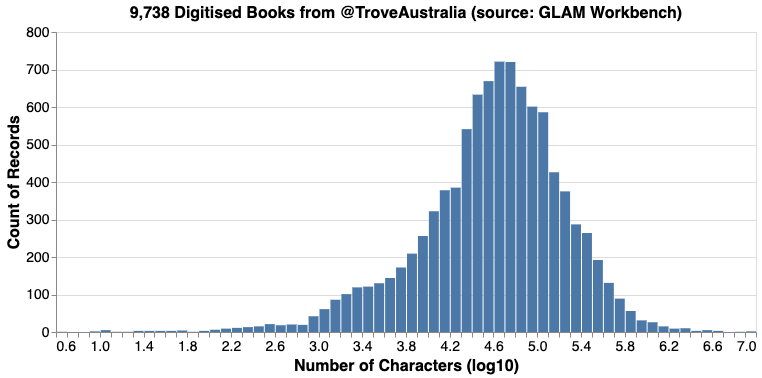

In [5]:
doc_lengths = pd.Series([len(p.read_text(encoding='utf-8').strip()) for p in docs_path]).rename('Document length')

source  = doc_lengths.map(np.log10).astype(float).to_frame()
chart = alt.Chart(source).mark_bar().encode(
    alt.X("Document length:Q", 
          bin=alt.Bin(maxbins=100), 
          title='Number of Characters (log10)',
         ),
    y='count()',
).properties(height=300, 
             width=700, 
             title=f'{doc_lengths.shape[0]:,} Digitised Books from @TroveAustralia (source: GLAM Workbench)')

chart.configure_axis(
    labelFontSize=14,
    titleFontSize=16
).configure_title(fontSize=16)

## Longest and shortest documents

In [6]:
print('\nLONGUEST DOCUMENTS:\n')
for i in doc_lengths.nlargest().index:
    print(f"{docs_path[i].name:<80} {doc_lengths.loc[i]:,.0f} characters.")
    print(f"{get_url(docs_path[i])[0]}")
    print(f"{get_url(docs_path[i])[1]}")


LONGUEST DOCUMENTS:

navigantium-atque-itinerantium-bibliotheca-or-a-nla.obj-302079118.txt            8,901,188 characters.
http://nla.gov.au/nla.obj-302079118
https://trove.nla.gov.au/work/16739978
navigantium-atque-itinerantium-bibliotheca-or-a-nla.obj-52928883.txt             8,669,438 characters.
http://nla.gov.au/nla.obj-52928883
https://trove.nla.gov.au/work/16739978
a-new-authentic-and-complete-collection-of-voyag-nla.obj-674833791.txt           7,672,397 characters.
http://nla.gov.au/nla.obj-674833791
https://trove.nla.gov.au/work/5769729
the-cyclopedia-of-western-australia-an-historica-nla.obj-135063414.txt           4,405,157 characters.
http://nla.gov.au/nla.obj-135063414
https://trove.nla.gov.au/work/12456547
official-record-of-the-debates-of-the-australasian-nla.obj-3821074.txt           4,329,931 characters.
http://nla.gov.au/nla.obj-3821074
https://trove.nla.gov.au/work/12982228


In [7]:
print('\nSHORTEST DOCUMENTS:\n')
for i in doc_lengths.nsmallest().index:
    print(f"{docs_path[i].name:<80} {doc_lengths.loc[i]:3d} characters.")
    print(f"{get_url(docs_path[i])[0]}")
    print(f"{get_url(docs_path[i])[1]}")


SHORTEST DOCUMENTS:

religious-sects-of-all-nations-nla.obj-187563224.txt                               4 characters.
http://nla.gov.au/nla.obj-187563224
https://trove.nla.gov.au/work/18240964
hear-heitmann-mp-wedderburn-victoria-oct-1-nla.obj-508107473.txt                   8 characters.
http://nla.gov.au/nla.obj-508107473
https://trove.nla.gov.au/work/228202997
chinesisch-und-tai-sprachvergleichende-untersuch-nla.obj-192209780.txt             9 characters.
http://nla.gov.au/nla.obj-192209780
https://trove.nla.gov.au/work/17417127
in-memoriam-emily-adeline-coleman-of-warbleton-nla.obj-363341982.txt              10 characters.
http://nla.gov.au/nla.obj-363341982
https://trove.nla.gov.au/work/12088738
a-st-albans-pioneer-nla.obj-362072830.txt                                         10 characters.
http://nla.gov.au/nla.obj-362072830
https://trove.nla.gov.au/work/12075464


While the longest documents look reasonable, the shortest ones are clearly documents for which the OCR process did not work...

## Topic Model
Before we can train a topic model we need to tokenise our document. Let's use the same tokenisation process that we used previously with the Australian parliamentary press releases.

In [8]:
%%time

corpus = (p.read_text(encoding='utf-8').strip() for p in docs_path)

X_tfidf, tfidf = tokenize(corpus,                     # the corpus
                          docs_path,                  # list of paths to the individual documents
                          min_df=10,                  # only consider words which appear in at least 10 docs
                          max_df=0.5,                 # only consider words which appear in at most 50% of the docs
                          lowercase=True,             # convert everything to lowercase
                          token_pattern='[a-z]{2,}',  # what's a token (2 or more letters)
                          stop_words=STOPWORDS,       # which words are to be excluded
                          max_features=10000          # keep the top 10,000 tokens (based on tfidf scores)
                         )

Tokenised 9738 documents using a vocabulary of 10000 tokens.
CPU times: user 1min 34s, sys: 3.54 s, total: 1min 37s
Wall time: 1min 37s


We can now train the model.

In [9]:
%%time
model = NMF(n_components=20, random_state=0)
X_nmf = model.fit_transform(X_tfidf)

CPU times: user 1min 3s, sys: 785 ms, total: 1min 4s
Wall time: 16.9 s


For future convenience, let's gather the results in a dataframe, and convert the topic scores into proportions.

We can then visualise how prevalent each topic is within the collection.

In [10]:
df = pd.DataFrame(X_nmf, columns=extract_topics(model, tfidf, n=5).values())
df = df.div(df.sum(axis=1), axis=0)     

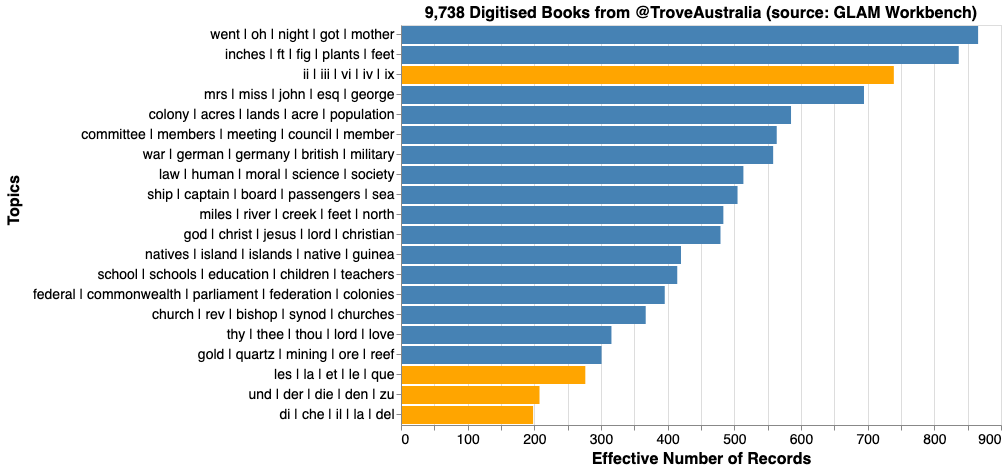

In [11]:
source = (df
          .sum(axis='rows')
          .rename('records')
          .reset_index()
          .sort_values('records')
          .assign(row=np.arange(df.shape[1]))
         )

chart = alt.Chart(source).mark_bar().encode(
   alt.X("records:Q", 
          title='Effective Number of Records',
         ),
    alt.Y("index", 
          title='Topics',
          sort=alt.EncodingSortField(
                    field="records",  
                    op="sum",  
                    order="descending"  
                    )
         ),
    color=alt.condition(
                alt.Predicate(
                    alt.FieldOneOfPredicate(field='row', oneOf=[0, 1 , 2, 17]),
                ),
                 alt.value('orange'),     
                 alt.value('steelblue'),   
                ),
).properties(height=400, 
             width=600, 
             title=f'{doc_lengths.shape[0]:,} Digitised Books from @TroveAustralia (source: GLAM Workbench)')

(chart
 .configure_axis(
    labelFontSize=14,
    titleFontSize=16,
    labelLimit=1000)
 .configure_title(fontSize=16)
 .configure_axisY(
    titleAngle=-90,
    titleAlign="left",
    titleX=-380)
)

In the plot above, I've highlighted 4 topics.
The ones at the bottom are clearly made up of common words in French, German, and Italian. 

This tells us that we have a multilingual collection.

The third topic from the top seems to be composed of Roman numerals. We'll need to have a closer look at it.

It is more convenient to use the topic number than the corresponding list of tokens
so let's extract the topic numbers.

In [12]:
topics = extract_topics(model, tfidf, n=5)
topics

{0: 'law | human | moral | science | society',
 1: 'ii | iii | vi | iv | ix',
 2: 'god | christ | jesus | lord | christian',
 3: 'went | oh | night | got | mother',
 4: 'les | la | et | le | que',
 5: 'mrs | miss | john | esq | george',
 6: 'miles | river | creek | feet | north',
 7: 'thy | thee | thou | lord | love',
 8: 'di | che | il | la | del',
 9: 'ship | captain | board | passengers | sea',
 10: 'war | german | germany | british | military',
 11: 'church | rev | bishop | synod | churches',
 12: 'und | der | die | den | zu',
 13: 'natives | island | islands | native | guinea',
 14: 'committee | members | meeting | council | member',
 15: 'inches | ft | fig | plants | feet',
 16: 'colony | acres | lands | acre | population',
 17: 'federal | commonwealth | parliament | federation | colonies',
 18: 'school | schools | education | children | teachers',
 19: 'gold | quartz | mining | ore | reef'}

### Topic 1: Documents consisting of Roman numerals? Not quite!

Looking at a few documents representative of this topic, we see that they are in Chinese.

In [13]:
chinese = get_most_representative_doc_for_topic(1, n=10, docs_path=docs_path, df=df, plot=False)

yesu-shi-ji-kao-nla.obj-55712310.txt
http://nla.gov.au/nla.obj-55712310
https://trove.nla.gov.au/work/12524291
gang-jian-yi-zhi-lu-wu-chengquan-deng-ji-nla.obj-57177068.txt
http://nla.gov.au/nla.obj-57177068
https://trove.nla.gov.au/work/12442950
sheng-jiao-yao-jing-by-t-dacosta-nla.obj-78179360.txt
http://nla.gov.au/nla.obj-78179360
https://trove.nla.gov.au/work/12535209
chu-deng-xiao-xue-nu-zi-guo-wen-jiao-ke-shu-nla.obj-45978562.txt
http://nla.gov.au/nla.obj-45978562
https://trove.nla.gov.au/work/12566013
shanghai-yu-ying-tang-zheng-xin-lu-nla.obj-48355311.txt
http://nla.gov.au/nla.obj-48355311
https://trove.nla.gov.au/work/12183597
yin-dou-lue-qiu-xi-shou-ji-nla.obj-46143424.txt
http://nla.gov.au/nla.obj-46143424
https://trove.nla.gov.au/work/12568110
yang-xin-shi-diao-du-jiade-zhuan-nla.obj-45188001.txt
http://nla.gov.au/nla.obj-45188001
https://trove.nla.gov.au/work/12537321
qin-ding-qian-lu-liang-shizheng-et-al-nla.obj-57037535.txt
http://nla.gov.au/nla.obj-57037535
https://trov

### Topic 4: French documents.

Topic 4 indeed corresponds to French documents.

In [14]:
french  = get_most_representative_doc_for_topic(4, n=10, docs_path=docs_path, df=df, plot=False)

voyage-en-australie-paul-gingeot-nla.obj-85784669.txt
http://nla.gov.au/nla.obj-85784669
https://trove.nla.gov.au/work/18869125
compte-rendu-par-l-envoye-extraordinaire-du-diable-nla.obj-19892684.txt
http://nla.gov.au/nla.obj-19892684
https://trove.nla.gov.au/work/32541149
discours-dur-roi-et-de-m-de-calonne-prononces-a-nla.obj-52882774.txt
http://nla.gov.au/nla.obj-52882774
https://trove.nla.gov.au/work/28493430
la-vie-des-animaux-et-des-plantes-dans-l-antarctiq-nla.obj-357092018.txt
http://nla.gov.au/nla.obj-357092018
https://trove.nla.gov.au/work/22328688
histoire-et-description-des-iles-sechelles-par-c-nla.obj-289639053.txt
http://nla.gov.au/nla.obj-289639053
https://trove.nla.gov.au/work/17828014
vers-le-pole-sud-conference-faite-a-la-sorbonne-nla.obj-357102024.txt
http://nla.gov.au/nla.obj-357102024
https://trove.nla.gov.au/work/22330839
notice-sur-le-guano-de-malden-pacifique-par-ma-nla.obj-52881455.txt
http://nla.gov.au/nla.obj-52881455
https://trove.nla.gov.au/work/22158247
le

### Topic 8: Italian documents.
Looks like topic 8 is made up of Italian documents. The third document below appears to have
a German title, however, if we follow the link to the NLA source, we can see that the document
is indeed in Italian.

In [15]:
italian = get_most_representative_doc_for_topic(8, n=10, docs_path=docs_path, df=df, plot=False)

compendio-della-storia-generale-de-viaggi-opera-nla.obj-549108466.txt
http://nla.gov.au/nla.obj-549108466
https://trove.nla.gov.au/work/6397064
compendio-della-storia-generale-de-viaggi-opera-nla.obj-553766859.txt
http://nla.gov.au/nla.obj-553766859
https://trove.nla.gov.au/work/6397064
die-schreiende-grube-roman-arthur-j-rees-b-nla.obj-182882753.txt
http://nla.gov.au/nla.obj-182882753
https://trove.nla.gov.au/work/9600166
compendio-della-storia-generale-de-viaggi-opera-nla.obj-549125673.txt
http://nla.gov.au/nla.obj-549125673
https://trove.nla.gov.au/work/6397064
compendio-della-storia-generale-de-viaggi-opera-nla.obj-549102470.txt
http://nla.gov.au/nla.obj-549102470
https://trove.nla.gov.au/work/6397064
compendio-della-storia-generale-de-viaggi-opera-nla.obj-555769345.txt
http://nla.gov.au/nla.obj-555769345
https://trove.nla.gov.au/work/6397064
piccolo-mondo-melanesiano-p-rinaldo-pavese-s-m-nla.obj-291156674.txt
http://nla.gov.au/nla.obj-291156674
https://trove.nla.gov.au/work/327998

### Topic 12: German documents.
Topic 12 seems to indeed correspond to German documents. Even the last document below, with its non-German title, is actually in German.

In [16]:
german = get_most_representative_doc_for_topic(12, n=10, docs_path=docs_path, df=df, plot=False)

beitrag-zur-kenntnis-der-morphologie-und-phylogeni-nla.obj-51079198.txt
http://nla.gov.au/nla.obj-51079198
https://trove.nla.gov.au/work/13002640
anthropologische-mittheilungen-uber-die-papuas-von-nla.obj-427926338.txt
http://nla.gov.au/nla.obj-427926338
https://trove.nla.gov.au/work/18725142
die-sudseeinseln-und-der-deutsche-sudseehandel-v-nla.obj-108484542.txt
http://nla.gov.au/nla.obj-108484542
https://trove.nla.gov.au/work/19242587
eine-sorgenfreie-zukunft-das-neue-evangelium-v-nla.obj-52869270.txt
http://nla.gov.au/nla.obj-52869270
https://trove.nla.gov.au/work/228963317
die-nutzpflanzen-von-neu-sudwales-von-othm-riet-nla.obj-63219759.txt
http://nla.gov.au/nla.obj-63219759
https://trove.nla.gov.au/work/18106322
anthropologische-mittheilungen-uber-die-papuas-von-nla.obj-79637099.txt
http://nla.gov.au/nla.obj-79637099
https://trove.nla.gov.au/work/18725142
die-ersten-bucher-des-wolkenwanderer-verlages-in-l-nla.obj-852288908.txt
http://nla.gov.au/nla.obj-852288908
https://trove.nla.g

## Dimensionality reduction

Let's visualise the whole collection using [UMAP](https://umap-learn.readthedocs.io/en/latest/).

We first compute a 2-dimensional embedding.

In [17]:
%%time
proj = UMAP(n_components=2, n_neighbors=30, min_dist=0.3, random_state=0)
X_proj = proj.fit_transform(X_nmf)

CPU times: user 28.1 s, sys: 1.38 s, total: 29.5 s
Wall time: 27.4 s


Then, we extract the dominant topic for each document, in order to use it to visualise how our collection is made up of different topics.

In [18]:
dominant_topic = X_nmf.argsort(axis=1)[:, -1]

df_proj = (pd.DataFrame(X_proj, columns=['x', 'y'])
               .assign(topic_num = dominant_topic)
          )
df_proj = df_proj.assign(topic=df_proj.topic_num.map(topics))
df_proj = pd.concat((df_proj, pd.DataFrame(df.values)), axis='columns')

Let's also identify which documents have one of the topics highlighed above as their dominant topic, and
use this information to plot the location of the non-English documents in the embedding.

In [19]:
lang_mask = {}

lang_subset = lambda t: df_proj.iloc[:, -model.n_components:].idxmax(axis=1).fillna(-1).astype(int) == t

lang_mask['chinese'] = lang_subset(1)
lang_mask['french']  = lang_subset(4)
lang_mask['italian'] = lang_subset(8)
lang_mask['german']  = lang_subset(12)

In [20]:
def plot_embedding(df_proj, xlim=None, ylim=None, hue='topic', palette='tab20', figsize=(18, 10)):

    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x='x', 
                    y='y', 
                    hue=hue, 
                    data=df_proj, 
                    palette=palette, 
                    alpha=0.8, 
                    s=50,
                    ax=ax)

    leg = ax.legend(bbox_to_anchor = (1.01, 1), markerscale=2, frameon=False, prop={"size":14})
    leg.texts[0].set_text("")
    leg.set_title(hue.title(), prop={"size":20})
    
    if xlim is not None:
        ax.set_xlim(xlim)
        ax.set_title('Topical portrait of the trove books', fontsize=18)
        
    if ylim is not None:
        ax.set_ylim(ylim)
        ax.get_legend().remove()    
        
    path_effects = [PathEffects.withStroke(linewidth=3, foreground="w")]
    
    for lang in lang_mask:
        x_ave, y_ave = df_proj.loc[lang_mask[lang], ['x', 'y']].median()
        ax.annotate(lang.title(), 
                    xy=(x_ave, y_ave), 
                    path_effects=path_effects,
                    fontsize=20)

    ax.set_axis_off() # comment this line to see the axes
    fig.tight_layout()

    return ax

def list_documents_in_frame(ax):
    indices = df_proj[df_proj.x.between(*ax.get_xlim()) & df_proj.y.between(*ax.get_ylim())].index.values
    return [docs_path[i] for i in indices]

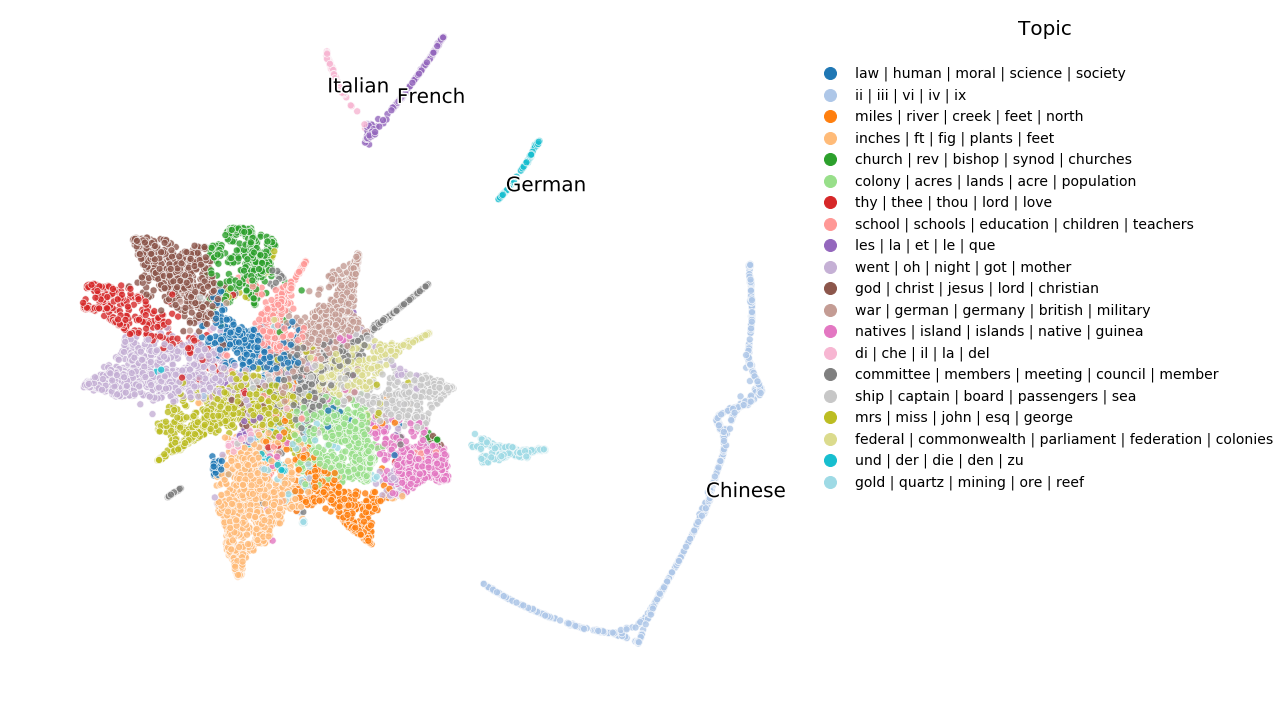

In [21]:
ax = plot_embedding(df_proj)

This looks quite interesting. The different languages are separated in the embedding. This is due to the fact that there is little to no overlap between the vocabularies of documents in different languages.
Essentially, using topic modelling we've performed a rudimentary form of language segmentation. 

Our approach, however, is far from perfect. First, with only 20 topics, we cannot guarantee that our list of topics is refined enough to detect all the languages present in the collection. Second, the "Chinese topic" is in reality a "non-Latin alphabet topic". Our cursory examination above seems to indicate that topic 1 is predominantly made up of Chinese documents, however, we should not conclude that the topic only "captures" Chinese documents. 

We need a more systematic way of determining the language of a document. 
After some experimentation I settled on [CLD2](https://github.com/CLD2Owners/cld2) which appears to work brilliantly.

## Language detection with CLD2

CLD2 doesn't just predict _the_ language of a document, it predicts up to 3 languages and provides their associated probabilities (i.e., how confident the algorithm is about its predictions). 
Since some of the trove documents appear to be made up of more than one language, this could be handy.

In [22]:
def predict_language(doc):
    pred = cld2.detect(doc.read_text('utf-8').strip())
    values = [pred[0]] + list(chain(*[(_[0].title(), _[2]) for _ in pred[2]]))
    keys = ['reliable',
            'lang0', 'prob0',
            'lang1', 'prob1',
            'lang2', 'prob2']
    return dict(zip(keys, values))

Let's test this on a subset of our documents. For instance, those I previously identified as in French, Italian, or German.

In [23]:
def check_language(subset=french):
    return pd.DataFrame([predict_language(doc) for doc in subset], 
                        index=[doc.name for doc in subset])

check_language()

,lang0,lang1,lang2,prob0,prob1,prob2,reliable
voyage-en-australie-paul-gingeot-nla.obj-85784669.txt,French,English,Unknown,99,0,0,True
compte-rendu-par-l-envoye-extraordinaire-du-diable-nla.obj-19892684.txt,French,Unknown,Unknown,99,0,0,True
discours-dur-roi-et-de-m-de-calonne-prononces-a-nla.obj-52882774.txt,French,Unknown,Unknown,99,0,0,True
la-vie-des-animaux-et-des-plantes-dans-l-antarctiq-nla.obj-357092018.txt,French,Unknown,Unknown,99,0,0,True
histoire-et-description-des-iles-sechelles-par-c-nla.obj-289639053.txt,French,English,Unknown,99,0,0,True
vers-le-pole-sud-conference-faite-a-la-sorbonne-nla.obj-357102024.txt,French,Unknown,Unknown,99,0,0,True
notice-sur-le-guano-de-malden-pacifique-par-ma-nla.obj-52881455.txt,French,Unknown,Unknown,99,0,0,True
lettre-de-m-h-d-de-blainville-a-m-le-redacteur-nla.obj-39360717.txt,French,English,Unknown,99,0,0,True
rapport-fait-a-la-convention-nationale-au-nom-du-nla.obj-193128113.txt,French,English,Unknown,99,0,0,True
talus-n-est-ce-que-cela-vraiment-je-voudrais-dire-nla.obj-500360847.txt,French,Unknown,Unknown,99,0,0,True


In [24]:
check_language(italian)

,lang0,lang1,lang2,prob0,prob1,prob2,reliable
compendio-della-storia-generale-de-viaggi-opera-nla.obj-549108466.txt,Italian,Corsican,Unknown,98,1,0,True
compendio-della-storia-generale-de-viaggi-opera-nla.obj-553766859.txt,Italian,Corsican,Unknown,99,0,0,True
die-schreiende-grube-roman-arthur-j-rees-b-nla.obj-182882753.txt,Italian,Corsican,Galician,99,0,0,True
compendio-della-storia-generale-de-viaggi-opera-nla.obj-549125673.txt,Italian,Rhaeto_Romance,Unknown,99,0,0,True
compendio-della-storia-generale-de-viaggi-opera-nla.obj-549102470.txt,Italian,Corsican,Unknown,99,0,0,True
compendio-della-storia-generale-de-viaggi-opera-nla.obj-555769345.txt,Italian,Unknown,Unknown,99,0,0,True
piccolo-mondo-melanesiano-p-rinaldo-pavese-s-m-nla.obj-291156674.txt,Italian,Unknown,Unknown,98,0,0,True
compendio-della-storia-generale-de-viaggi-opera-nla.obj-554099544.txt,Italian,Unknown,Unknown,99,0,0,True
compendio-della-storia-generale-de-viaggi-opera-nla.obj-554063610.txt,Italian,Danish,Unknown,99,0,0,True
gausava-storia-di-una-scuola-di-catechisti-un-nla.obj-291285408.txt,Italian,English,Unknown,98,0,0,True


In [25]:
check_language(german)

,lang0,lang1,lang2,prob0,prob1,prob2,reliable
beitrag-zur-kenntnis-der-morphologie-und-phylogeni-nla.obj-51079198.txt,German,English,French,99,0,0,True
anthropologische-mittheilungen-uber-die-papuas-von-nla.obj-427926338.txt,German,English,Unknown,99,0,0,True
die-sudseeinseln-und-der-deutsche-sudseehandel-v-nla.obj-108484542.txt,German,Unknown,Unknown,99,0,0,True
eine-sorgenfreie-zukunft-das-neue-evangelium-v-nla.obj-52869270.txt,German,Unknown,Unknown,99,0,0,True
die-nutzpflanzen-von-neu-sudwales-von-othm-riet-nla.obj-63219759.txt,German,Unknown,Unknown,99,0,0,True
anthropologische-mittheilungen-uber-die-papuas-von-nla.obj-79637099.txt,German,French,English,99,0,0,True
die-ersten-bucher-des-wolkenwanderer-verlages-in-l-nla.obj-852288908.txt,German,English,Unknown,92,5,0,True
max-klingers-beethoven-kurze-erlauterung-nla.obj-503146672.txt,German,Unknown,Unknown,99,0,0,True
fuhrer-und-rathgeber-fur-auswanderer-nach-sud-aust-nla.obj-52765537.txt,German,Unknown,Unknown,99,0,0,True
concert-programmes-etc-nla.obj-530514315.txt,German,Unknown,Unknown,99,0,0,True


## Let's apply CLD2 to the entire collection

In [26]:
%%time

df_lang = (pd.DataFrame([predict_language(doc) for doc in docs_path], 
                       index=[p.name for p in docs_path])
           .reset_index()
           .rename({'index':'document'}, axis=1)
          )

df_lang['url_nla'] = df_lang.document.apply(lambda x: get_url(Path('data')/x)[0])

df_lang['url_trove'] = df_lang.document.apply(lambda x: get_url(Path('data')/x)[1])

df_lang.to_csv('language_prediction.csv', index=False)

CPU times: user 1min 27s, sys: 1.95 s, total: 1min 29s
Wall time: 1min 29s


Considering we have more than 9,000 documents, this is impressively fast!

CLD2 has 2 categories for Chinese, which I'll merge.

In [27]:
df_lang = pd.read_csv('language_prediction.csv').replace('Chineset','Chinese')
df_lang.head()

,document,lang0,lang1,lang2,prob0,prob1,prob2,reliable,url_nla,url_trove
0,the-convict-system-of-van-diemen-s-land-by-fre...,English,French,Unknown,99,0,0,True,http://nla.gov.au/nla.obj-248637531,https://trove.nla.gov.au/work/18731141
1,gang-jian-yi-zhi-lu-wu-chengquan-deng-ji-nla.o...,Chinese,Unknown,Unknown,95,0,0,True,http://nla.gov.au/nla.obj-57177037,https://trove.nla.gov.au/work/12442950
2,mr-d-mcintyre-s-journey-across-australia-from-...,English,Unknown,Unknown,99,0,0,True,http://nla.gov.au/nla.obj-62054977,https://trove.nla.gov.au/work/18289823
3,some-hitherto-unknown-australian-plants-descri...,English,Unknown,Unknown,99,0,0,True,http://nla.gov.au/nla.obj-47482369,https://trove.nla.gov.au/work/18104297
4,baptists-in-victoria-our-first-century-1838-19...,English,Unknown,Unknown,99,0,0,True,http://nla.gov.au/nla.obj-28794937,https://trove.nla.gov.au/work/8483648


CDL2 returns a _reliable_ flag. We've got slighly more than 300 documents classified as unreliable.
Out of 9,738 documents it's not a big deal. 

In [28]:
(~df_lang.reliable).sum()

324

We'll leave those aside for now and focus on the rest.

Let's see which languages CLD2 has detected.

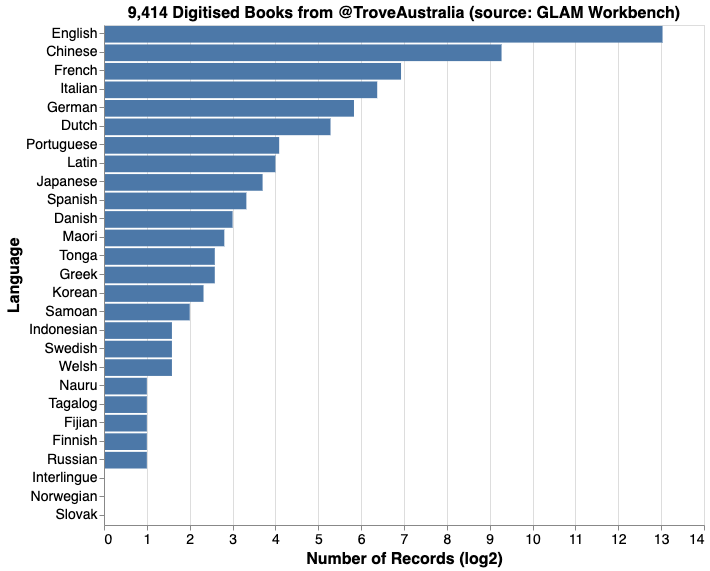

In [29]:
source = (df_lang[df_lang.reliable]
 .lang0
 .value_counts()
 .to_frame()
 .assign(Records=lambda x: np.log2(x.lang0))
 .reset_index()
 .rename({'index':'Language','lang0':'Number of documents'}, axis=1)
)

chart = alt.Chart(source).mark_bar().encode(
   alt.X("Records:Q", 
          title='Number of Records (log2)',
         ),
    alt.Y("Language", 
          sort=alt.EncodingSortField(
                    field="Records",  # The field to use for the sort
                    op="sum",  # The operation to run on the field prior to sorting
                    order="descending"  # The order to sort in
                    )
         ),
).properties(height=500, 
             width=600, 
             title=f'{df_lang[df_lang.reliable].shape[0]:,} Digitised Books from @TroveAustralia (source: GLAM Workbench)')

(chart
 .configure_axis(
    labelFontSize=14,
    titleFontSize=16,
    labelLimit=1000)
 .configure_title(fontSize=16)
)

Note that once again I've taken the logarithm (base 2 this time) of the number of records, therefore
a score of 0 corresponds to a single document found in the collection (as seems to be the case for Slovak, for instance).

Now that we've incorporated the language information, we can easily extract a list of documents for any of the languages detected by CLD2. 

In [30]:
def get_docs_for_lang(lang=None):
    selection = df_lang[df_lang.lang0==lang.title()]
    return selection

get_docs_for_lang('Russian')

,document,lang0,lang1,lang2,prob0,prob1,prob2,reliable,url_nla,url_trove
3192,slovo-o-uspekhark-plavaniia-shliupov-vostoka-i...,Russian,Unknown,Unknown,82,0,0,True,http://nla.gov.au/nla.obj-52868130,https://trove.nla.gov.au/work/21352421
6085,serviliia-opera-v-piati-deistviiakh-libretto-n...,Russian,Unknown,Unknown,91,0,0,True,https://nla.gov.au/nla.obj-325248898,https://trove.nla.gov.au/work/21729488


#### Which documents are predicted to have significant contributions from 2 languages.

In [31]:
df_lang[(df_lang.prob0 > 40) & (df_lang.prob1 > 40)]

,document,lang0,lang1,lang2,prob0,prob1,prob2,reliable,url_nla,url_trove
932,explanation-of-the-print-sujet-de-l-estampe-nl...,French,English,Unknown,52,47,0,True,http://nla.gov.au/nla.obj-125569476,https://trove.nla.gov.au/work/20737794
1091,han-zi-zhi-xin-li-yan-jiu-ai-wei-bian-zhu-nla....,Chinese,Chinese,Unknown,53,43,0,True,http://nla.gov.au/nla.obj-82521266,https://trove.nla.gov.au/work/14511899
2835,table-des-planches-enlumineez-d-histoire-natur...,French,English,Unknown,45,42,0,True,http://nla.gov.au/nla.obj-546027537,https://trove.nla.gov.au/work/22326223
2974,elements-de-la-construction-picturale-apercu-d...,French,English,Unknown,51,48,0,True,http://nla.gov.au/nla.obj-52813589,https://trove.nla.gov.au/work/18815414
3285,hume-and-hovell-s-overland-expedition-1824-25-...,English,French,Unknown,51,48,0,True,http://nla.gov.au/nla.obj-251368722,https://trove.nla.gov.au/work/18757514
4654,le-voyage-de-monsieur-perrichon-or-mr-perricho...,English,French,Unknown,51,48,0,True,http://nla.gov.au/nla.obj-77603831,https://trove.nla.gov.au/work/18655824
4922,ile-christmas-south-seas-oceanie-coconuts-bi-n...,English,French,Unknown,51,48,0,True,http://nla.gov.au/nla.obj-698564,https://trove.nla.gov.au/work/6370813
5627,la-neige-un-souvenir-de-matyas-bernard-braun-n...,French,Slovak,Unknown,52,47,0,True,http://nla.gov.au/nla.obj-500369283,https://trove.nla.gov.au/work/6172612
5633,la-joie-fait-peur-or-the-joy-that-causes-fear-...,English,French,Unknown,51,48,0,True,http://nla.gov.au/nla.obj-77603781,https://trove.nla.gov.au/work/18655885
5892,acte-final-de-la-conference-internationale-des...,English,French,Unknown,52,47,0,True,http://nla.gov.au/nla.obj-52022203,https://trove.nla.gov.au/work/34631188


Looking at the source URLs, some of these make perfect sense (like the first one), but others might be a sign of a failed OCR process. The occurence of document with "Chinese" for both `lang0` and `lang1` is just an artefact of my merging the "Chinese" and "ChineseT" (traditional) categories.

#### Any document with 3 predicted languages?

In [33]:
df_lang[(df_lang.prob0 > 20) & (df_lang.prob1 > 20) & (df_lang.prob2 > 20)]

,document,lang0,lang1,lang2,prob0,prob1,prob2,reliable,url_nla,url_trove


Apparently not!

## Unreliable languages

Let's revisit those _unrealiable_ language predictions. For some CLD2 isn't even able to make a language prediction.

In [34]:
unreliable_lang = df_lang[~df_lang.reliable].set_index('document')[['lang0','url_nla']]
unreliable_lang.head(15)

,lang0,url_nla
document,,
a-bush-christening-poem-by-a-b-paterson-illus-nla.obj-290693249.txt,Unknown,http://nla.gov.au/nla.obj-290693249
to-let-apply-to-c-j-t-ham-45-swanston-stree-nla.obj-20522034.txt,Unknown,http://nla.gov.au/nla.obj-20522034
saturday-november-12-1859-the-performances-will-c-nla.obj-76427416.txt,Unknown,http://nla.gov.au/nla.obj-76427416
form-letter-from-the-colonial-department-regardin-nla.obj-25653502.txt,Unknown,http://nla.gov.au/nla.obj-25653502
first-book-and-hymnal-pangkumu-and-aulua-maleku-nla.obj-265728037.txt,Unknown,http://nla.gov.au/nla.obj-265728037
catalogo-dei-libri-impressi-nella-reale-stamperia-nla.obj-37133222.txt,Italian,http://nla.gov.au/nla.obj-37133222
san-zi-jing-nla.obj-46923245.txt,Chinese,http://nla.gov.au/nla.obj-46923245
progress-in-1897-imperial-federation-defence-nla.obj-67680895.txt,Unknown,http://nla.gov.au/nla.obj-67680895
ying-huan-zhi-lue-xu-jiyu-ji-zhu-bi-xingqua-nla.obj-114731594.txt,Chinese,http://nla.gov.au/nla.obj-114731594


A quick look at the source will reveal that some of these documents are either handwritten, or using peculiar typography, which wreaks havoc on the OCR process. 

This is easily confirmed by looking at the corresponding OCR'd text.

In [35]:
!head -n 40 {Path('books/a-bush-christening-poem-by-a-b-paterson-illus-nla.obj-290693249.txt')}



v
.
,■ ' •' ; • •"• ’ '• . • ‘ • - . . _ - ' • / • ‘ £
\ Al ,
,/r Y CW^J ^I
SB&sssp «Stsg^^
tA^Sjxggsm
\itf been mwJXCf ■
frsoncMnkuhM&
mxcifommli
chriftctw
rAWinnisi
I
I
I> 2S.*VE W O GJ> 2O O o ' ' “ . ~ *7 ~ 7 ~" ' -- - ~i\


In [36]:
!head -n 40 {Path('books/to-let-apply-to-c-j-t-ham-45-swanston-stree-nla.obj-20522034.txt')}



_.j- : VsTOS',-MS ■ .-ir-' : -' ' : :-"! ; tt§:-*fri ; -^!'h:'-',’f: : |i ' ; ftmV~?'^‘ : ;«*it-':?:::c;v • :x^r»:.’I.>•, ■ !.'“• •
'. ■ 265 y \ - . : t;f
If?'” , ", ■ 1 .:"’ : ; -•*;'.•■■ ■ ■ ! %-ir■ .;■•”;?>. : ljrc;&':i. : ;.jUs , '.
i ■ - .-.-v. ; -i-:,,- ' :■:&■ ;■.:■■
Si Si SiSSi —
■g mm gg| HH
B m WMiBI
■ m gn mi
lWff* lwS H BSSS&lf iM«3iMSjg«£i:
M p ffi Sm M ®
s
g g
g
g g
g
g g g
1 w—' - ■ ■ ' ■' 1 1 ,l "" 1 * 1 i . I ■■■-— —m !i \tmrn,
APPLY TO
L
I
I
f> 4>> ; ;; : ... ~
.
pß|p fIHIB
&
jftfe Bflf IH wB jpp BHI ■Hi sm 18, BBb *B BBS 3MBI BWI sbr.
Jr
Stillwell and Knight, Printers, 78 Oolllns-street East.
o


###### Interestingly, even a perfectly legible digitised text will confuse CLD2 if it starts with a few gibberish characters.

In [37]:
!head -n 40 {Path('books/memorial-on-behalf-of-the-crown-tenants-of-victor-nla.obj-73416856.txt')}



<!#Zn*^2^^L
L -6C _
/ X X
TO THE
RIGHT HONORABLE HENRY LABOUOHERE,
SECRETARY OF STATE FOR THE COLONIES,
THE MEMORIAL
ON BEHALF OF
THE CROWN TENANTS OF VICTORIA;
Humbly Shewethy
THAT the unsettled state of the Land Question in Victoria is injurious to the peace and prosperity
of the Australian Colonies; and that your Memorialist, therefore, begs to draw your attention to the
state of that long vexed question, by submitting the following brief statement of facts, and references
to the Order in Council, and Proclamations of the Governor General:?
1. By the Act 9 and 10 Victoria, and by the Order in Council of the 9th March 1847, a right to
a Lease, and pre-emptive right to purchase, was granted to the Licensed Occupants of Crown Lands in
New South Wales, which then included Victoria.
2. By Proclamation of the 7th October 1847, the Order in Council was made to have the force and �
effect of law in the Colony.
3. Under an Act of the Government of New South Wales, assented to on the 17th J

##### Perhaps surprisingly, omitting the leading 3 characters of this document is enough to clear any confusion for CLD2.

In [38]:
print(cld2
      .detect(Path('books/memorial-on-behalf-of-the-crown-tenants-of-victor-nla.obj-73416856.txt')
              .read_text()))

print(cld2
      .detect(Path('books/memorial-on-behalf-of-the-crown-tenants-of-victor-nla.obj-73416856.txt')
              .read_text()[3:]))

(False, 0, (('Unknown', 'un', 0, 0.0), ('Unknown', 'un', 0, 0.0), ('Unknown', 'un', 0, 0.0)))
(True, 6695, (('ENGLISH', 'en', 99, 1328.0), ('Unknown', 'un', 0, 0.0), ('Unknown', 'un', 0, 0.0)))


## Top 10 languages (other than English)



In [39]:
tmp = df_proj.copy()
tmp.insert(2, 'language', df_lang.lang0)
tmp=tmp[tmp.language.isin(source.Language[1:11])] # start a 1 to exclude English

def plot_embedding_lang(df_proj, xlim=None, ylim=None, hue='topic', palette='tab10', figsize=(18, 10)):

    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(x='x', 
                    y='y', 
                    hue=hue, 
                    data=df_proj, 
                    palette=palette, 
                    alpha=0.8, 
                    s=100,
                    ax=ax)

    leg = ax.legend(bbox_to_anchor = (1.02, 1), markerscale=2, frameon=False, prop={"size":14})
    leg.texts[0].set_text("")
    leg.set_title(hue.title(), prop={"size":20})
    
    if xlim is not None:
        ax.set_xlim(xlim)
        ax.set_title('Topical portrait of the trove books', fontsize=18)
        
    if ylim is not None:
        ax.set_ylim(ylim)
        ax.get_legend().remove()    
            
    return ax

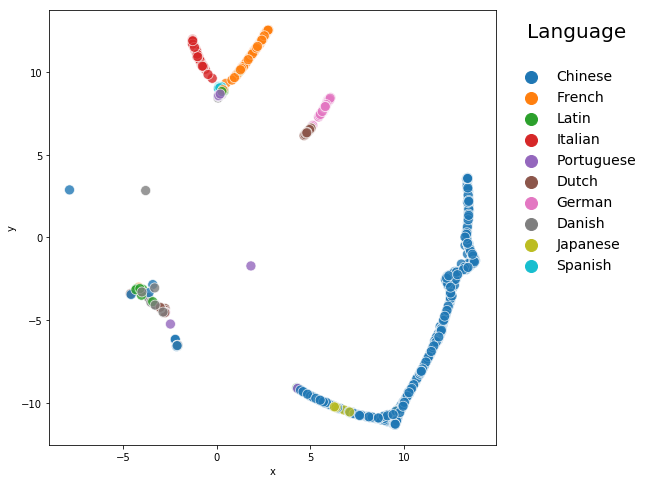

In [40]:
ax = plot_embedding_lang(tmp, hue='language', figsize=(8, 8))

We now see a more nuanced picture of the languages found in the collection. Interestingly, we see Japanese documents within what we previously labelled as the Chinese cluster, and we observe Spanish and Portuguese documents located somewhere between the French and Italian clusters, as well as Dutch documents near the German cluster.

It may be suprising to see dots in the area where English documents would be, however, let's not forget that some documents are multilingual, which might explain some of the smaller features observed in the figure.

Since the vast majority of the documents are in English, let's focus on those and train a new topic model.

# English documents only

In [41]:
mask_english = (df_lang.lang0 == 'English').values
en_docs_paths = np.array(docs_path)[mask_english]

english_corpus = (p.read_text(encoding='utf-8').strip() 
                  for p in en_docs_paths)

X_tfidf_en, tfidf_en = tokenize(english_corpus,       # the corpus
                          docs_path,                  # list of paths to the individual documents
                          min_df=10,                  # only consider words which appear in at least 10 docs
                          max_df=0.5,                 # only consider words which appear in at most 50% of the docs
                          lowercase=True,             # convert everything to lowercase
                          token_pattern='[a-z]{2,}',  # what's a token (2 or more letters)
                          stop_words=STOPWORDS,       # which words are to be excluded
                          max_features=10000          # keep the top 10,000 tokens (based on tfidf scores)
                         )

Tokenised 8428 documents using a vocabulary of 10000 tokens.


In [42]:
%%time
model_en = NMF(n_components=20, random_state=0)
X_nmf_en = model_en.fit_transform(X_tfidf_en)

CPU times: user 1min 37s, sys: 935 ms, total: 1min 38s
Wall time: 25.5 s


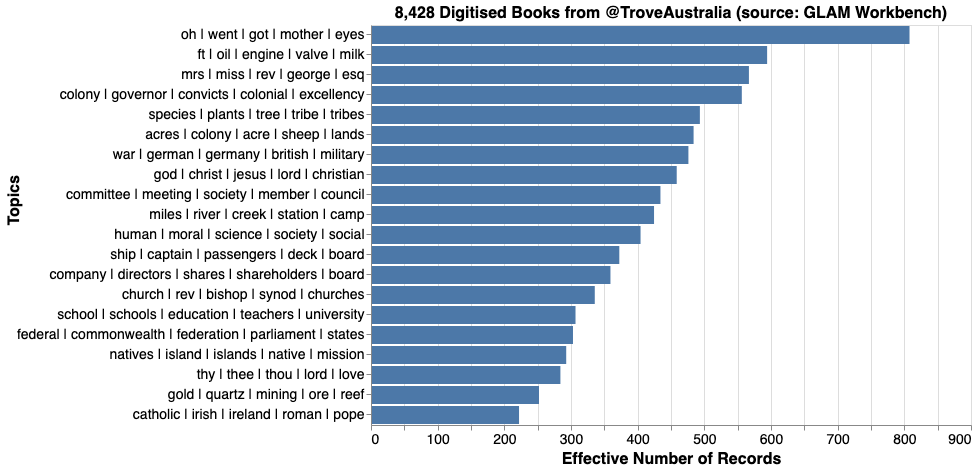

In [43]:
df_en = pd.DataFrame(X_nmf_en, columns=extract_topics(model_en, tfidf_en, n=5).values())
df_en = df_en.div(df_en.sum(axis=1), axis=0)     

source = (df_en
          .sum(axis='rows')
          .rename('records')
          .reset_index()
          .sort_values('records')
          .assign(row=np.arange(df_en.shape[1]))
         )

chart = alt.Chart(source).mark_bar().encode(
   alt.X("records:Q", 
          title='Effective Number of Records',
         ),
    alt.Y("index", 
          title='Topics',
          sort=alt.EncodingSortField(
                    field="records",  
                    op="sum",  
                    order="descending"  
                    )
         ),
).properties(height=400, 
             width=600, 
             title=f'{df_en.shape[0]:,} Digitised Books from @TroveAustralia (source: GLAM Workbench)')

(chart
 .configure_axis(
    labelFontSize=14,
    titleFontSize=16,
    labelLimit=1000)
 .configure_title(fontSize=16)
 .configure_axisY(
    titleAngle=-90,
    titleAlign="left",
    titleX=-350)
)

Just like before, let's extract the topic numbers.

In [44]:
topics_en = extract_topics(model_en, tfidf_en)
topics_en

{0: 'human | moral | science | society | social',
 1: 'god | christ | jesus | lord | christian',
 2: 'oh | went | got | mother | eyes',
 3: 'church | rev | bishop | synod | churches',
 4: 'miles | river | creek | station | camp',
 5: 'thy | thee | thou | lord | love',
 6: 'ship | captain | passengers | deck | board',
 7: 'war | german | germany | british | military',
 8: 'catholic | irish | ireland | roman | pope',
 9: 'species | plants | tree | tribe | tribes',
 10: 'committee | meeting | society | member | council',
 11: 'ft | oil | engine | valve | milk',
 12: 'colony | governor | convicts | colonial | excellency',
 13: 'federal | commonwealth | federation | parliament | states',
 14: 'natives | island | islands | native | mission',
 15: 'gold | quartz | mining | ore | reef',
 16: 'mrs | miss | rev | george | esq',
 17: 'school | schools | education | teachers | university',
 18: 'company | directors | shares | shareholders | board',
 19: 'acres | colony | acre | sheep | lands'}

By extracting 10 representative documents for each topics, we can get a feel for what the topic is about,
and try to come up with a shorter, hopefully more transparent name for the topics.

My attempt at this is given below. If you click on the NLA or Trove links you can see for yourself what the documents are about, and whether my classification makes sense.

### Topic: human | moral | science | society | social  ==> Philosophy

In [45]:
_ = get_most_representative_doc_for_topic(0, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

fact-and-idea-by-c-j-brennan-nla.obj-384185248.txt
http://nla.gov.au/nla.obj-384185248
https://trove.nla.gov.au/work/20989676
a-treatise-on-the-evolution-of-historical-organism-nla.obj-385701594.txt
http://nla.gov.au/nla.obj-385701594
https://trove.nla.gov.au/work/12524435
the-subjection-of-women-by-hokor-henry-keylock-nla.obj-72931807.txt
http://nla.gov.au/nla.obj-72931807
https://trove.nla.gov.au/work/18608287
physical-sexual-and-natural-religion-by-a-stud-nla.obj-52870895.txt
http://nla.gov.au/nla.obj-52870895
https://trove.nla.gov.au/work/17922400
free-will-and-determinism-an-essay-on-the-subjec-nla.obj-421372509.txt
http://nla.gov.au/nla.obj-421372509
https://trove.nla.gov.au/work/18783476
science-and-theology-an-essay-a-reprint-dedica-nla.obj-135164132.txt
http://nla.gov.au/nla.obj-135164132
https://trove.nla.gov.au/work/13264747
conversion-in-science-by-g-elliot-smith-nla.obj-52812500.txt
http://nla.gov.au/nla.obj-52812500
https://trove.nla.gov.au/work/34387289
the-vortices-demo

### Topic: god | christ | jesus | lord | christian ==> Christian Theology

In [46]:
_ = get_most_representative_doc_for_topic(1, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

a-catechism-of-scripture-doctrine-for-junior-class-nla.obj-387174951.txt
http://nla.gov.au/nla.obj-387174951
https://trove.nla.gov.au/work/17809744
the-christ-of-the-flesh-and-the-christ-of-the-spir-nla.obj-651215639.txt
http://nla.gov.au/nla.obj-651215639
https://trove.nla.gov.au/work/23426117
the-grace-of-divine-healing-and-the-secret-of-mi-nla.obj-43062826.txt
http://nla.gov.au/nla.obj-43062826
https://trove.nla.gov.au/work/10372293
the-first-catechism-being-for-the-use-of-the-infan-nla.obj-464816922.txt
http://nla.gov.au/nla.obj-464816922
https://trove.nla.gov.au/work/23164730
conditional-immortality-as-taught-in-the-new-testa-nla.obj-416502794.txt
http://nla.gov.au/nla.obj-416502794
https://trove.nla.gov.au/work/22206638
grace-preserving-and-crowning-jude-24-a-farewel-nla.obj-475652272.txt
http://nla.gov.au/nla.obj-475652272
https://trove.nla.gov.au/work/23198924
christ-our-sanctification-by-dougan-clark-nla.obj-390032743.txt
http://nla.gov.au/nla.obj-390032743
https://trove.nla.g

### Topic: oh | went | got | mother | eyes ==> Children's Books

This is an interesting topic. Apparently the vocabulary used in children's books is sufficiently distinct from that of the other documents that the algorithm was able to cluster these documents together.

In [47]:
_ = get_most_representative_doc_for_topic(2, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

the-wand-of-dawn-by-minnie-i-rowe-illustratio-nla.obj-32189819.txt
http://nla.gov.au/nla.obj-32189819
https://trove.nla.gov.au/work/19120970
teddy-at-the-circus-by-fred-j-nicoll-nla.obj-73166801.txt
http://nla.gov.au/nla.obj-73166801
https://trove.nla.gov.au/work/7264684
our-funny-mummy-written-and-illustrated-by-toby-nla.obj-25624874.txt
http://nla.gov.au/nla.obj-25624874
https://trove.nla.gov.au/work/19178152
teddy-in-fairyland-by-fred-j-nicoll-nla.obj-21528887.txt
http://nla.gov.au/nla.obj-21528887
https://trove.nla.gov.au/work/13071609
teddy-counts-his-pots-by-fred-j-nicoll-nla.obj-3148864.txt
http://nla.gov.au/nla.obj-3148864
https://trove.nla.gov.au/work/7264696
lucky-rolling-stone-by-helen-alderson-illustra-nla.obj-18215346.txt
http://nla.gov.au/nla.obj-18215346
https://trove.nla.gov.au/work/19201184
little-miss-anzac-the-true-story-of-an-australia-nla.obj-69640239.txt
http://nla.gov.au/nla.obj-69640239
https://trove.nla.gov.au/work/30156472
cinderella-s-party-a-fairy-story-by-m

### Topic: church | rev | bishop | synod | churches ==> Church Administration

In [48]:
_ = get_most_representative_doc_for_topic(3, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

st-saviour-s-cathedral-goulburn-nla.obj-569777680.txt
http://nla.gov.au/nla.obj-569777680
https://trove.nla.gov.au/work/13377959
objections-to-the-unions-chiefly-from-the-point-nla.obj-422392408.txt
http://nla.gov.au/nla.obj-422392408
https://trove.nla.gov.au/work/22034330
scot-s-church-property-bill-john-gardner-nla.obj-398787573.txt
http://nla.gov.au/nla.obj-398787573
https://trove.nla.gov.au/work/35080272
order-of-proceedings-of-the-ceremony-of-unveiling-nla.obj-448308376.txt
http://nla.gov.au/nla.obj-448308376
https://trove.nla.gov.au/work/18173133
narrative-of-the-disruption-of-the-presbyterian-ch-nla.obj-422097743.txt
http://nla.gov.au/nla.obj-422097743
https://trove.nla.gov.au/work/34425077
the-recent-outrage-at-the-scots-church-nla.obj-415141094.txt
http://nla.gov.au/nla.obj-415141094
https://trove.nla.gov.au/work/10223781
the-church-of-scotland-and-the-church-of-england-i-nla.obj-645021966.txt
http://nla.gov.au/nla.obj-645021966
https://trove.nla.gov.au/work/23456296
the-scots

### Topic: miles | river | creek | station | camp ==> Australian Travels

I'm sure there's a better name for this topic... _Exploring Australia_ maybe?

In [49]:
_ = get_most_representative_doc_for_topic(4, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

across-australia-by-motor-nla.obj-52794967.txt
http://nla.gov.au/nla.obj-52794967
https://trove.nla.gov.au/work/20808142
journal-of-mr-lewis-s-lake-eyre-expedition-1874-5-nla.obj-255318866.txt
http://nla.gov.au/nla.obj-255318866
https://trove.nla.gov.au/work/37571515
report-of-a-trip-to-the-fitzroy-river-from-roebuck-nla.obj-43388592.txt
http://nla.gov.au/nla.obj-43388592
https://trove.nla.gov.au/work/19231525
diary-of-the-exploring-expedition-led-by-w-j-o-nla.obj-52759620.txt
http://nla.gov.au/nla.obj-52759620
https://trove.nla.gov.au/work/22036027
cyclists-touring-guide-of-new-south-wales-josep-nla.obj-204577885.txt
http://nla.gov.au/nla.obj-204577885
https://trove.nla.gov.au/work/18370999
report-on-proposed-railway-line-marble-bar-to-po-nla.obj-52815274.txt
http://nla.gov.au/nla.obj-52815274
https://trove.nla.gov.au/work/22333890
illustrations-to-the-diaries-of-burke-wills-expe-nla.obj-490941350.txt
https://nla.gov.au/nla.obj-490941350
https://trove.nla.gov.au/work/26359927
diary-of

### Topic: thy | thee | thou | lord | love ==> Church Services

Mostly funerals....

In [50]:
_ = get_most_representative_doc_for_topic(5, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

through-much-tribulation-by-alpha-omega-a-j-a-nla.obj-193473024.txt
http://nla.gov.au/nla.obj-193473024
https://trove.nla.gov.au/work/18587283
funeral-service-of-the-late-william-thompson-past-nla.obj-368784260.txt
http://nla.gov.au/nla.obj-368784260
https://trove.nla.gov.au/work/18235579
order-of-service-for-the-funeral-of-the-late-honou-nla.obj-365725473.txt
http://nla.gov.au/nla.obj-365725473
https://trove.nla.gov.au/work/12422705
order-of-service-for-the-funeral-of-the-late-honou-nla.obj-375441567.txt
http://nla.gov.au/nla.obj-375441567
https://trove.nla.gov.au/work/18236569
order-of-service-for-the-funeral-of-the-late-brian-nla.obj-368781285.txt
http://nla.gov.au/nla.obj-368781285
https://trove.nla.gov.au/work/13749315
in-memoriam-the-hon-sir-julian-salomons-knight-nla.obj-368189600.txt
http://nla.gov.au/nla.obj-368189600
https://trove.nla.gov.au/work/18172760
funeral-service-of-the-venerable-william-martin-m-nla.obj-366624916.txt
http://nla.gov.au/nla.obj-366624916
https://trove.

### Topic: ship | captain | passengers | deck | board ==> Maritime History

In [51]:
_ = get_most_representative_doc_for_topic(6, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

captain-jorgensen-s-life-boat-the-storm-king-an-nla.obj-753184412.txt
http://nla.gov.au/nla.obj-753184412
https://trove.nla.gov.au/work/19117713
the-loss-of-the-steam-ship-london-by-one-of-the-nla.obj-222827309.txt
http://nla.gov.au/nla.obj-222827309
https://trove.nla.gov.au/work/19295164
a-narrative-of-the-wreck-of-the-meridian-on-the-i-nla.obj-52793640.txt
http://nla.gov.au/nla.obj-52793640
https://trove.nla.gov.au/work/28343755
the-loss-of-his-majesty-s-frigate-anson-which-was-nla.obj-237892916.txt
http://nla.gov.au/nla.obj-237892916
https://trove.nla.gov.au/work/21570671
the-wreck-of-the-royal-charter-compiled-from-a-nla.obj-395637356.txt
http://nla.gov.au/nla.obj-395637356
https://trove.nla.gov.au/work/33651048
waifs-and-strays-of-sea-life-and-adventure-picke-nla.obj-746294656.txt
http://nla.gov.au/nla.obj-746294656
https://trove.nla.gov.au/work/18862139
waifs-and-strays-of-sea-life-and-adventure-picke-nla.obj-352214218.txt
http://nla.gov.au/nla.obj-352214218
https://trove.nla.gov

### Topic: war | german | germany | british | military ==> Military History

In [52]:
_ = get_most_representative_doc_for_topic(7, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

the-immediate-responsibility-for-the-war-being-a-nla.obj-37352755.txt
http://nla.gov.au/nla.obj-37352755
https://trove.nla.gov.au/work/25557449
how-the-war-came-with-a-chronicle-of-events-comp-nla.obj-35040923.txt
http://nla.gov.au/nla.obj-35040923
https://trove.nla.gov.au/work/26643429
the-french-yellow-book-revelations-of-german-gui-nla.obj-35177135.txt
http://nla.gov.au/nla.obj-35177135
https://trove.nla.gov.au/work/26658073
germany-and-england-by-robert-blatchford-nla.obj-36479976.txt
http://nla.gov.au/nla.obj-36479976
https://trove.nla.gov.au/work/19321280
german-and-volks-migration-will-flood-australia-wi-nla.obj-445378230.txt
https://nla.gov.au/nla.obj-445378230
https://trove.nla.gov.au/work/22301375
anzac-autograph-album-25th-april-1916-souvenir-nla.obj-37871545.txt
http://nla.gov.au/nla.obj-37871545
https://trove.nla.gov.au/work/26753059
potsdam-poison-by-w-lewis-nla.obj-142002.txt
http://nla.gov.au/nla.obj-142002
https://trove.nla.gov.au/work/26658998
the-red-book-a-post-bell

### Topic: catholic | irish | ireland | roman | pope ==> Catholicism in Ireland

In [53]:
_ = get_most_representative_doc_for_topic(8, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

address-of-the-queensland-irish-and-to-irishmen-nla.obj-475979075.txt
https://nla.gov.au/nla.obj-475979075
https://trove.nla.gov.au/work/11717214
irish-history-its-lessons-to-england-by-t-e-nla.obj-18830331.txt
http://nla.gov.au/nla.obj-18830331
https://trove.nla.gov.au/work/7134225
bundled-out-nla.obj-38091103.txt
http://nla.gov.au/nla.obj-38091103
https://trove.nla.gov.au/work/26841230
an-extensive-popular-fraud-nla.obj-395029038.txt
http://nla.gov.au/nla.obj-395029038
https://trove.nla.gov.au/work/34905457
grievances-in-ireland-by-one-of-the-tolerant-maj-nla.obj-37124284.txt
http://nla.gov.au/nla.obj-37124284
https://trove.nla.gov.au/work/6370114
the-story-of-ulster-a-lecture-by-alex-leeper-nla.obj-74695798.txt
http://nla.gov.au/nla.obj-74695798
https://trove.nla.gov.au/work/18638302
open-letter-to-archbishop-mannix-of-melbourne-and-nla.obj-40581971.txt
http://nla.gov.au/nla.obj-40581971
https://trove.nla.gov.au/work/19265894
the-coming-battle-christianity-s-riddle-ireland-nla.obj-4

### Topic: species | plants | tree | tribe | tribes ==> Australian Fauna & Flaura

Would _Natural History_ be a better choice?

In [54]:
_ = get_most_representative_doc_for_topic(9, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

guide-to-the-australian-fossil-remains-exhibited-b-nla.obj-71020267.txt
http://nla.gov.au/nla.obj-71020267
https://trove.nla.gov.au/work/18541963
zoology-of-australia-by-the-hon-w-macleay-nla.obj-422192929.txt
http://nla.gov.au/nla.obj-422192929
https://trove.nla.gov.au/work/22391825
a-list-of-the-insectivorous-birds-of-new-south-wal-nla.obj-436907833.txt
http://nla.gov.au/nla.obj-436907833
https://trove.nla.gov.au/work/18975897
gould-s-birds-of-australia-nla.obj-39334651.txt
http://nla.gov.au/nla.obj-39334651
https://trove.nla.gov.au/work/16826676
tabular-list-of-all-the-australian-birds-at-presen-nla.obj-498679790.txt
http://nla.gov.au/nla.obj-498679790
https://trove.nla.gov.au/work/22563528
notes-on-the-fauna-of-tasmania-by-gerard-krefft-nla.obj-356331668.txt
http://nla.gov.au/nla.obj-356331668
https://trove.nla.gov.au/work/18917253
plants-collected-in-capricornic-western-australia-nla.obj-63216173.txt
http://nla.gov.au/nla.obj-63216173
https://trove.nla.gov.au/work/18106523
the-bir

### Topic: committee | meeting | society | member | council ==> Rules & Regulations

Couldn't think of a better name...

In [55]:
_ = get_most_representative_doc_for_topic(10, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

constitution-and-rules-aborigines-progressive-as-nla.obj-52781302.txt
http://nla.gov.au/nla.obj-52781302
https://trove.nla.gov.au/work/14615105
code-of-laws-of-the-melbourne-mechanics-instituti-nla.obj-39904435.txt
http://nla.gov.au/nla.obj-39904435
https://trove.nla.gov.au/work/13474030
rules-of-the-queensland-articled-clerks-society-nla.obj-469280219.txt
http://nla.gov.au/nla.obj-469280219
https://trove.nla.gov.au/work/23165828
aborigines-progressive-association-general-meeting-nla.obj-67672291.txt
http://nla.gov.au/nla.obj-67672291
https://trove.nla.gov.au/work/31138955
rules-of-the-jamberoo-school-of-arts-nla.obj-39534967.txt
http://nla.gov.au/nla.obj-39534967
https://trove.nla.gov.au/work/19201073
rules-of-the-photographic-society-of-victoria-wi-nla.obj-70307974.txt
http://nla.gov.au/nla.obj-70307974
https://trove.nla.gov.au/work/18349008
rules-and-regulations-of-the-adelaide-choral-socie-nla.obj-370188058.txt
http://nla.gov.au/nla.obj-370188058
https://trove.nla.gov.au/work/17622

### Topic: ft | oil | engine | valve | milk ==> Weights & Measures

I was quite puzzled by this topic when I first saw it. What do units of measurement, mechanical parts, and milk have to do with one another? It became clearer when I looked a the documents. 
This selection seems to be part owner's manuals for various vehicles, and cooking recipes. 
I suppose it all makes sense. These are two areas where measuring things accurately matters.

This is a nice illustration of how this type of algorithm will create clusters purely based on word usage.
I suspect these two areas of interests might split into their own topics if we increased the number of topics.

In [56]:
_ = get_most_representative_doc_for_topic(11, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

operating-maintenance-manual-with-parts-catalogu-nla.obj-404680622.txt
http://nla.gov.au/nla.obj-404680622
https://trove.nla.gov.au/work/24424312
1951-chevrolet-passenger-car-and-coupe-utility-spe-nla.obj-293495993.txt
http://nla.gov.au/nla.obj-293495993
https://trove.nla.gov.au/work/31243729
the-moto-reve-motor-cycle-nla.obj-40168955.txt
http://nla.gov.au/nla.obj-40168955
https://trove.nla.gov.au/work/6804521
instruction-book-for-k-l-bulldog-crude-oil-tract-nla.obj-52792564.txt
http://nla.gov.au/nla.obj-52792564
https://trove.nla.gov.au/work/18672352
owner-s-and-driver-s-manual-motor-trucks-models-nla.obj-52849534.txt
http://nla.gov.au/nla.obj-52849534
https://trove.nla.gov.au/work/24895045
handbook-for-the-ordnance-b-l-9-2-inch-marks-x-nla.obj-288099979.txt
http://nla.gov.au/nla.obj-288099979
https://trove.nla.gov.au/work/18993530
service-manual-for-wolseley-14-60-and-18-85-1945-nla.obj-262974754.txt
http://nla.gov.au/nla.obj-262974754
https://trove.nla.gov.au/work/7285751
the-nurse-

### Topic: colony | governor | convicts | colonial | excellency ==> Colonial History

In [57]:
_ = get_most_representative_doc_for_topic(12, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

the-washerwoman-of-melbourne-to-his-excellency-nla.obj-486260765.txt
https://nla.gov.au/nla.obj-486260765
https://trove.nla.gov.au/work/22411086
transportation-message-no-2-despatches-from-t-nla.obj-719754025.txt
http://nla.gov.au/nla.obj-719754025
https://trove.nla.gov.au/work/24493324
memorial-services-for-queen-victoria-nla.obj-371236666.txt
http://nla.gov.au/nla.obj-371236666
https://trove.nla.gov.au/work/12401736
two-letters-written-in-van-diemen-s-land-shewing-nla.obj-52763104.txt
http://nla.gov.au/nla.obj-52763104
https://trove.nla.gov.au/work/15263034
contribution-from-the-british-treasury-enclosure-nla.obj-719754030.txt
http://nla.gov.au/nla.obj-719754030
https://trove.nla.gov.au/work/24493763
notice-to-the-superintendent-of-the-road-party-nla.obj-99008222.txt
http://nla.gov.au/nla.obj-99008222
https://trove.nla.gov.au/work/11861860
notice-to-prisoners-under-sentence-of-transportati-nla.obj-76410716.txt
http://nla.gov.au/nla.obj-76410716
https://trove.nla.gov.au/work/34694699


### Topic: federal | commonwealth | federation | parliament | states ==> Australian Federation

In [58]:
_ = get_most_representative_doc_for_topic(13, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

synopsis-of-the-commonwealth-bill-approved-by-th-nla.obj-688657366.txt
http://nla.gov.au/nla.obj-688657366
https://trove.nla.gov.au/work/23560157
12-camera-snapshots-of-canberra-australian-capit-nla.obj-118187465.txt
http://nla.gov.au/nla.obj-118187465
https://trove.nla.gov.au/work/194488782
the-democratic-element-in-australian-federation-nla.obj-411390706.txt
http://nla.gov.au/nla.obj-411390706
https://trove.nla.gov.au/work/16993997
notes-on-australian-federation-its-nature-and-pr-nla.obj-716906721.txt
http://nla.gov.au/nla.obj-716906721
https://trove.nla.gov.au/work/7931838
the-federal-financial-problem-and-its-solution-b-nla.obj-390010119.txt
http://nla.gov.au/nla.obj-390010119
https://trove.nla.gov.au/work/25391043
essays-and-addresses-on-the-australian-commonwealt-nla.obj-1459817.txt
http://nla.gov.au/nla.obj-1459817
https://trove.nla.gov.au/work/18363611
the-commonwealth-of-australia-four-lectures-on-t-nla.obj-429338128.txt
http://nla.gov.au/nla.obj-429338128
https://trove.nla.go

### Topic: natives | island | islands | native | mission ==> Islands of Oceania

In [59]:
_ = get_most_representative_doc_for_topic(14, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

note-on-the-people-and-languages-of-new-ireland-an-nla.obj-97654817.txt
http://nla.gov.au/nla.obj-97654817
https://trove.nla.gov.au/work/19405685
voyages-of-the-dutch-brig-of-war-dourga-through-nla.obj-61877302.txt
http://nla.gov.au/nla.obj-61877302
https://trove.nla.gov.au/work/18353124
cruises-in-melanesia-micronesia-and-western-poly-nla.obj-101217424.txt
http://nla.gov.au/nla.obj-101217424
https://trove.nla.gov.au/work/19241448
picturesque-new-guinea-nla.obj-375690830.txt
http://nla.gov.au/nla.obj-375690830
https://trove.nla.gov.au/work/17732210
you-and-the-native-notes-for-the-guidance-of-mem-nla.obj-52800158.txt
http://nla.gov.au/nla.obj-52800158
https://trove.nla.gov.au/work/19305090
oriental-and-oceanic-pictures-ltd-melbourne-pres-nla.obj-16047975.txt
http://nla.gov.au/nla.obj-16047975
https://trove.nla.gov.au/work/21442026
the-new-hebrideans-by-jas-h-lawrie-nla.obj-52766396.txt
http://nla.gov.au/nla.obj-52766396
https://trove.nla.gov.au/work/12441434
map-of-british-new-guinea-f

### Topic: gold | quartz | mining | ore | reef ==> Gold Mining

Mining has also left its imprint on this collection it seems...

In [60]:
_ = get_most_representative_doc_for_topic(15, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

gold-mining-in-queensland-nla.obj-78386941.txt
http://nla.gov.au/nla.obj-78386941
https://trove.nla.gov.au/work/18372644
queensland-minerals-at-the-colonies-exhibition-18-nla.obj-78361843.txt
http://nla.gov.au/nla.obj-78361843
https://trove.nla.gov.au/work/18370547
letter-on-the-nature-and-origin-of-the-gold-deposi-nla.obj-83938574.txt
http://nla.gov.au/nla.obj-83938574
https://trove.nla.gov.au/work/18368838
the-pambula-gold-deposits-nla.obj-44292264.txt
http://nla.gov.au/nla.obj-44292264
https://trove.nla.gov.au/work/34658833
gold-a-sequel-to-my-pamphlet-on-gold-and-mining-nla.obj-423787693.txt
http://nla.gov.au/nla.obj-423787693
https://trove.nla.gov.au/work/22478959
the-gold-fields-of-australia-by-j-t-towson-nla.obj-235281169.txt
http://nla.gov.au/nla.obj-235281169
https://trove.nla.gov.au/work/6524727
on-gold-washing-nla.obj-77465715.txt
http://nla.gov.au/nla.obj-77465715
https://trove.nla.gov.au/work/18531622
gold-and-mining-by-henry-marshall-nla.obj-423787632.txt
http://nla.gov.a

### Topic: mrs | miss | rev | george | esq ==> Registries 

There must be a better name for this topic...

In [61]:
_ = get_most_representative_doc_for_topic(16, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

miss-rosa-cooper-and-mr-lionel-harding-in-their-w-nla.obj-48484976.txt
http://nla.gov.au/nla.obj-48484976
https://trove.nla.gov.au/work/11660522
at-home-on-thursday-the-24th-april-1930-the-mus-nla.obj-531929944.txt
http://nla.gov.au/nla.obj-531929944
https://trove.nla.gov.au/work/19149669
register-of-qualified-teachers-of-music-and-adjudi-nla.obj-52807676.txt
http://nla.gov.au/nla.obj-52807676
https://trove.nla.gov.au/work/17751338
farewell-benefit-for-j-c-williamson-niblo-s-gard-nla.obj-343592159.txt
http://nla.gov.au/nla.obj-343592159
https://trove.nla.gov.au/work/21479651
wallack-s-friday-evening-april-5th-1867-nla.obj-342311811.txt
http://nla.gov.au/nla.obj-342311811
https://trove.nla.gov.au/work/21054147
book-of-remembrance-of-the-pioneer-women-of-the-po-nla.obj-28583642.txt
http://nla.gov.au/nla.obj-28583642
https://trove.nla.gov.au/work/12800901
diana-of-dobson-s-with-miss-tittell-brune-also-mr-nla.obj-48421380.txt
http://nla.gov.au/nla.obj-48421380
https://trove.nla.gov.au/work

### Topic: school | schools | education | teachers | university ==> Education

In [62]:
_ = get_most_representative_doc_for_topic(17, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

high-schools-versus-scholarships-an-enquiry-into-nla.obj-52845278.txt
http://nla.gov.au/nla.obj-52845278
https://trove.nla.gov.au/work/22336776
report-of-the-committee-appointed-to-survey-second-nla.obj-493015703.txt
https://nla.gov.au/nla.obj-493015703
https://trove.nla.gov.au/work/6475673
partnering-a-better-future-national-indigenous-e-nla.obj-44237718.txt
http://nla.gov.au/nla.obj-44237718
https://trove.nla.gov.au/work/34133993
a-report-following-upon-observations-of-american-e-nla.obj-43591248.txt
http://nla.gov.au/nla.obj-43591248
https://trove.nla.gov.au/work/17845703
free-education-a-word-in-favour-of-the-system-nla.obj-673398587.txt
http://nla.gov.au/nla.obj-673398587
https://trove.nla.gov.au/work/23592356
the-public-school-system-of-new-south-wales-by-f-nla.obj-52820604.txt
http://nla.gov.au/nla.obj-52820604
https://trove.nla.gov.au/work/11928781
public-education-in-new-zealand-a-speech-deliver-nla.obj-95881249.txt
http://nla.gov.au/nla.obj-95881249
https://trove.nla.gov.au/w

### Topic: company | directors | shares | shareholders | board ==> Deeds & Certificates

Not the greatest name, but I couldn't think of anything better...

In [63]:
_ = get_most_representative_doc_for_topic(18, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

memorandum-and-articles-of-association-of-kiku-gum-nla.obj-2307465.txt
http://nla.gov.au/nla.obj-2307465
https://trove.nla.gov.au/work/18349371
deed-of-settlement-of-the-australian-general-assur-nla.obj-379532023.txt
http://nla.gov.au/nla.obj-379532023
https://trove.nla.gov.au/work/17764508
certificate-of-incorporation-nla.obj-20913121.txt
http://nla.gov.au/nla.obj-20913121
https://trove.nla.gov.au/work/186340937
deed-of-settlement-of-the-hunter-river-new-steam-n-nla.obj-406553423.txt
http://nla.gov.au/nla.obj-406553423
https://trove.nla.gov.au/work/10730609
deed-of-settlement-of-the-queensland-steam-navigat-nla.obj-471597604.txt
http://nla.gov.au/nla.obj-471597604
https://trove.nla.gov.au/work/23167572
deed-of-settlement-of-the-australasian-steam-navig-nla.obj-394446183.txt
http://nla.gov.au/nla.obj-394446183
https://trove.nla.gov.au/work/17714446
verbatim-report-of-mr-justice-vaughan-williams-s-nla.obj-108455834.txt
http://nla.gov.au/nla.obj-108455834
https://trove.nla.gov.au/work/19

### Topic: acres | colony | acre | sheep | lands ==> Land & Leases

In [64]:
_ = get_most_representative_doc_for_topic(19, n=10, docs_path=en_docs_paths, df=df_en, plot=False)

more-people-wanted-in-queensland-australia-fre-nla.obj-113306013.txt
http://nla.gov.au/nla.obj-113306013
https://trove.nla.gov.au/work/18112861
our-waste-lands-by-s-newland-nla.obj-72111399.txt
http://nla.gov.au/nla.obj-72111399
https://trove.nla.gov.au/work/18575100
sheep-and-wool-in-new-south-wales-with-history-a-nla.obj-390631645.txt
http://nla.gov.au/nla.obj-390631645
https://trove.nla.gov.au/work/17882720
geelong-on-monday-7th-of-september-1857-nla.obj-103707201.txt
http://nla.gov.au/nla.obj-103707201
https://trove.nla.gov.au/work/170158665
how-to-settle-on-the-land-in-the-colony-of-queensl-nla.obj-114203475.txt
http://nla.gov.au/nla.obj-114203475
https://trove.nla.gov.au/work/17843184
new-south-wales-land-laws-the-central-division-nla.obj-384264685.txt
http://nla.gov.au/nla.obj-384264685
https://trove.nla.gov.au/work/21009632
new-south-wales-the-oldest-colony-of-the-austral-nla.obj-82106243.txt
http://nla.gov.au/nla.obj-82106243
https://trove.nla.gov.au/work/18869238
from-laboure

Let's rename the topics using the shorter names I've introduced above.

In [65]:
short_topics_en = {0:  'Philosophy',
                   1:  'Christian Theology',
                   2:  "Children's Books",
                   3:  'Church Administration',
                   4:  'Australian Travels',
                   5:  'Church Services',
                   6:  'Maritime History',
                   7:  'Military History',
                   8:  'Catholicism in Ireland',
                   9:  "Australian Fauna & Flora",
                   10: 'Rules & Regulations',
                   11: 'Weights & Measures',
                   12: 'Colonial Australia',
                   13: 'Autralian Federation',
                   14: "Islands of Oceania",
                   15: 'Gold Mining',
                   16: 'Registries',
                   17: 'Education',
                   18: 'Deeds & Certificates',
                   19: 'Land & Leases'}

We can now recompute a 2D embedding just for the English documents.

In [66]:
%%time
proj_en = UMAP(n_components=2, n_neighbors=30, min_dist=0.9, random_state=0)
X_proj_en = proj.fit_transform(X_nmf_en)

CPU times: user 18.5 s, sys: 1.15 s, total: 19.7 s
Wall time: 18.2 s


In [67]:
dominant_topic_en = X_nmf_en.argsort(axis=1)[:, -1]

df_proj_en = (pd.DataFrame(X_proj_en, columns=['x', 'y'])
               .assign(topic_num = dominant_topic_en)
          )
df_proj_en = df_proj_en.assign(topic=df_proj_en.topic_num.map(short_topics_en))
df_proj_en = pd.concat((df_proj_en, pd.DataFrame(df_en.values)), axis='columns')

df_proj_en.index = [p.name for p in en_docs_paths]
source = df_proj_en.iloc[:, :4].reset_index().rename({'index':'document'},axis=1)
source['url'] = source.document.map(lambda x: get_url(Path(x))[1])

# Final result

Let's create an interactive embedding plot where we can pan and zoom, and where hovering over a circle will tell us the name of the document as well as its dominant topic.

By clicking on any circle (⌘-click on a Mac) we will be taken to the source document on [Trove](https://trove.nla.gov.au/).

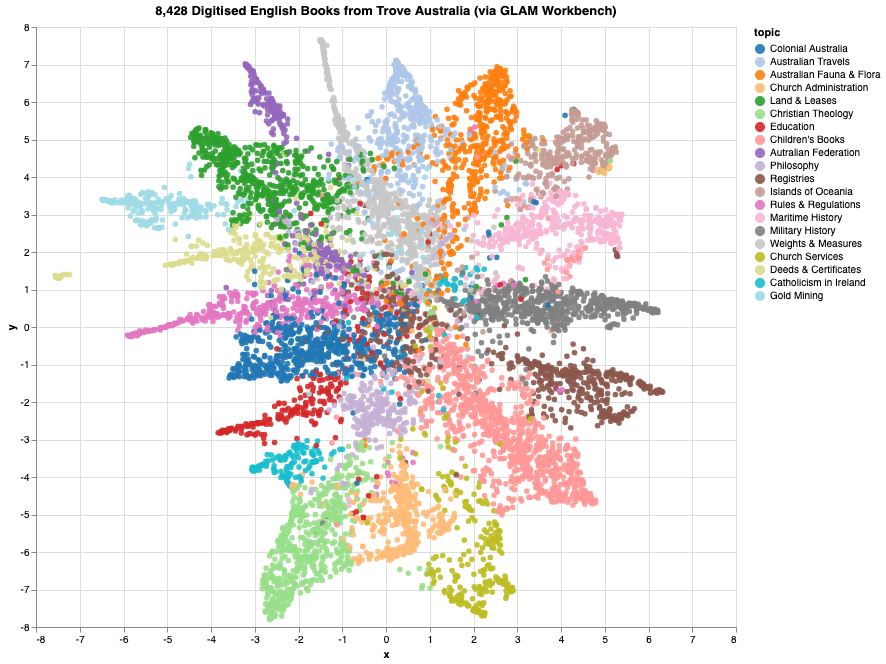

In [68]:
title = f'{df_en.shape[0]:,} Digitised English Books from Trove Australia (via GLAM Workbench)'

chart = (alt.Chart(source).mark_circle(size=30).encode(
            x='x',
            y='y',
            color=alt.Color('topic', 
                            scale=alt.Scale(scheme='category20'),
                            sort=df_en.sum(axis='rows').sort_values().index.to_list()[::-1]
                           ),
            opacity=alt.value(0.9),
            tooltip=['topic', 'document'],
            href='url:N'
            )
         .properties(height=600, 
             width=700, 
             title=title
                )
         .configure_legend(labelLimit= 0)
         .interactive()
        )
chart

# Online app

Note that this figure can be saved as a stand-alone HMTL document, which can then be modified and deployed online as  [I have done here](https://trove-english-books.herokuapp.com/).

Uncomment the next cell to save the figure to a file.

In [69]:
# chart.save('./Trove_English_Books_Embedding.html')

# Conclusion

I confess that I started the analysis knowing nothing about the collection. I was therefore surprised to find out that it contained documents in several languages. The CLD2 library was very helpful in determining the language
of the documents, sometimes exceeding my expectations, as [I mentioned here](https://twitter.com/DinkumData/status/1132826239071268864). 

The analysis of the collection of English documents was also interesting, revealing an unexpected (at least for me) selection of topics, and illustrating once again that these machine learning techniques can be helpful in extracting  insight from a collection of documents. 

Finally, I'd like to once again thank [Tim Sherratt](https://timsherratt.org/) for his wonderful work with [GLAM Workbench](https://glam-workbench.github.io/), and for making collections of digitised documents like this one so easily accessible.

----
Copyright &copy; 2019 <a href="https://twitter.com/dinkumdata">Adel Rahmani</a>. 

The text is released under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>, and the code is released under the <a href="https://opensource.org/licenses/MIT">MIT license</a>.